In [41]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Any
from tqdm.notebook import tqdm
import re

# --- Configuration ---
ANALYSIS_RESULTS_BASE_DIR = Path(os.path.expanduser("~/slimsc/prune/analysis")) # Base dir where analysis was saved
SC_RESULTS_BASE_DIR = Path(os.path.expanduser("~/slimsc/prune/results"))
MODEL_NAME = "R1-Distill-Qwen-14B"
DATASET_NAME = "gpqa_diamond"
N_START_VALUES_ANALYZED = [2, 4, 8, 16, 32] # List the N values you analyzed
# Thresholds should ideally be inferred from data, but specify if needed for ordering
# THRESHOLDS_ANALYZED = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] # List the thresholds analyzed

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Default figure size

# Configure matplotlib for better display in notebooks
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # For higher resolution plots

In [42]:
def load_aggregated_results(base_dir: str, model: str, dataset: str, n_start_values: List[int]) -> Optional[pd.DataFrame]:
    """Loads aggregated metrics from JSON files for multiple n_start values."""
    all_data = []
    found_thresholds = set()

    for n in n_start_values:
        run_name = f"hypothesis_analysis_n{n}"
        metrics_path = os.path.join(base_dir, model, dataset, run_name, "aggregated_metrics.json")

        if not os.path.exists(metrics_path):
            print(f"Warning: Aggregated metrics file not found for N={n} at {metrics_path}. Skipping.")
            continue

        try:
            with open(metrics_path, 'r') as f:
                data = json.load(f)

            results_by_thresh = data.get("results_by_threshold", {})
            num_questions = data.get("num_questions_analyzed", 0)

            for thresh_str, metrics in results_by_thresh.items():
                try:
                    threshold = float(thresh_str)
                    found_thresholds.add(threshold)
                    all_data.append({
                        "n_start": n,
                        "threshold": threshold,
                        "num_questions": num_questions,
                        "total_detected": metrics.get("total_similar_pairs_detected", 0),
                        "total_same_answer": metrics.get("total_similar_pairs_same_answer", 0),
                        "overall_perc_same": metrics.get("overall_same_answer_percentage"), # This is the key metric
                        "mean_perc_same": metrics.get("mean_same_answer_percentage_per_question")
                    })
                except ValueError:
                    print(f"Warning: Could not parse threshold '{thresh_str}' as float for N={n}. Skipping this threshold.")
                except Exception as e:
                     print(f"Warning: Error processing threshold '{thresh_str}' for N={n}: {e}. Skipping.")

        except Exception as e:
            print(f"Error loading or parsing file {metrics_path}: {e}")

    if not all_data:
        print("Error: No data loaded. Please check paths and ensure analysis ran successfully.")
        return None

    df = pd.DataFrame(all_data)
    # Ensure correct types
    df['n_start'] = df['n_start'].astype(int)
    df['threshold'] = df['threshold'].astype(float)
    df['total_detected'] = df['total_detected'].astype(int)
    df['total_same_answer'] = df['total_same_answer'].astype(int)
    df['overall_perc_same'] = pd.to_numeric(df['overall_perc_same'], errors='coerce')
    df['mean_perc_same'] = pd.to_numeric(df['mean_perc_same'], errors='coerce')

    # Sort for consistent plotting
    df = df.sort_values(by=["n_start", "threshold"]).reset_index(drop=True)

    print(f"Successfully loaded data for N values: {sorted(df['n_start'].unique())}")
    print(f"Found thresholds: {sorted(list(found_thresholds))}")

    return df

# Load the data
results_df = load_aggregated_results(
    ANALYSIS_RESULTS_BASE_DIR,
    MODEL_NAME,
    DATASET_NAME,
    N_START_VALUES_ANALYZED
)

# Display the first few rows to verify
if results_df is not None:
    print("\nLoaded Data Head:")
    print(results_df.head())
else:
    print("\nData loading failed.")

Successfully loaded data for N values: [2, 4, 8, 16, 32]
Found thresholds: [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Loaded Data Head:
   n_start  threshold  num_questions  total_detected  total_same_answer  \
0        2       0.65             50              46                 35   
1        2       0.70             50              46                 35   
2        2       0.75             50              46                 35   
3        2       0.80             50              45                 34   
4        2       0.85             50              43                 32   

   overall_perc_same  mean_perc_same  
0          76.086957       76.086957  
1          76.086957       76.086957  
2          76.086957       76.086957  
3          75.555556       75.555556  
4          74.418605       74.418605  


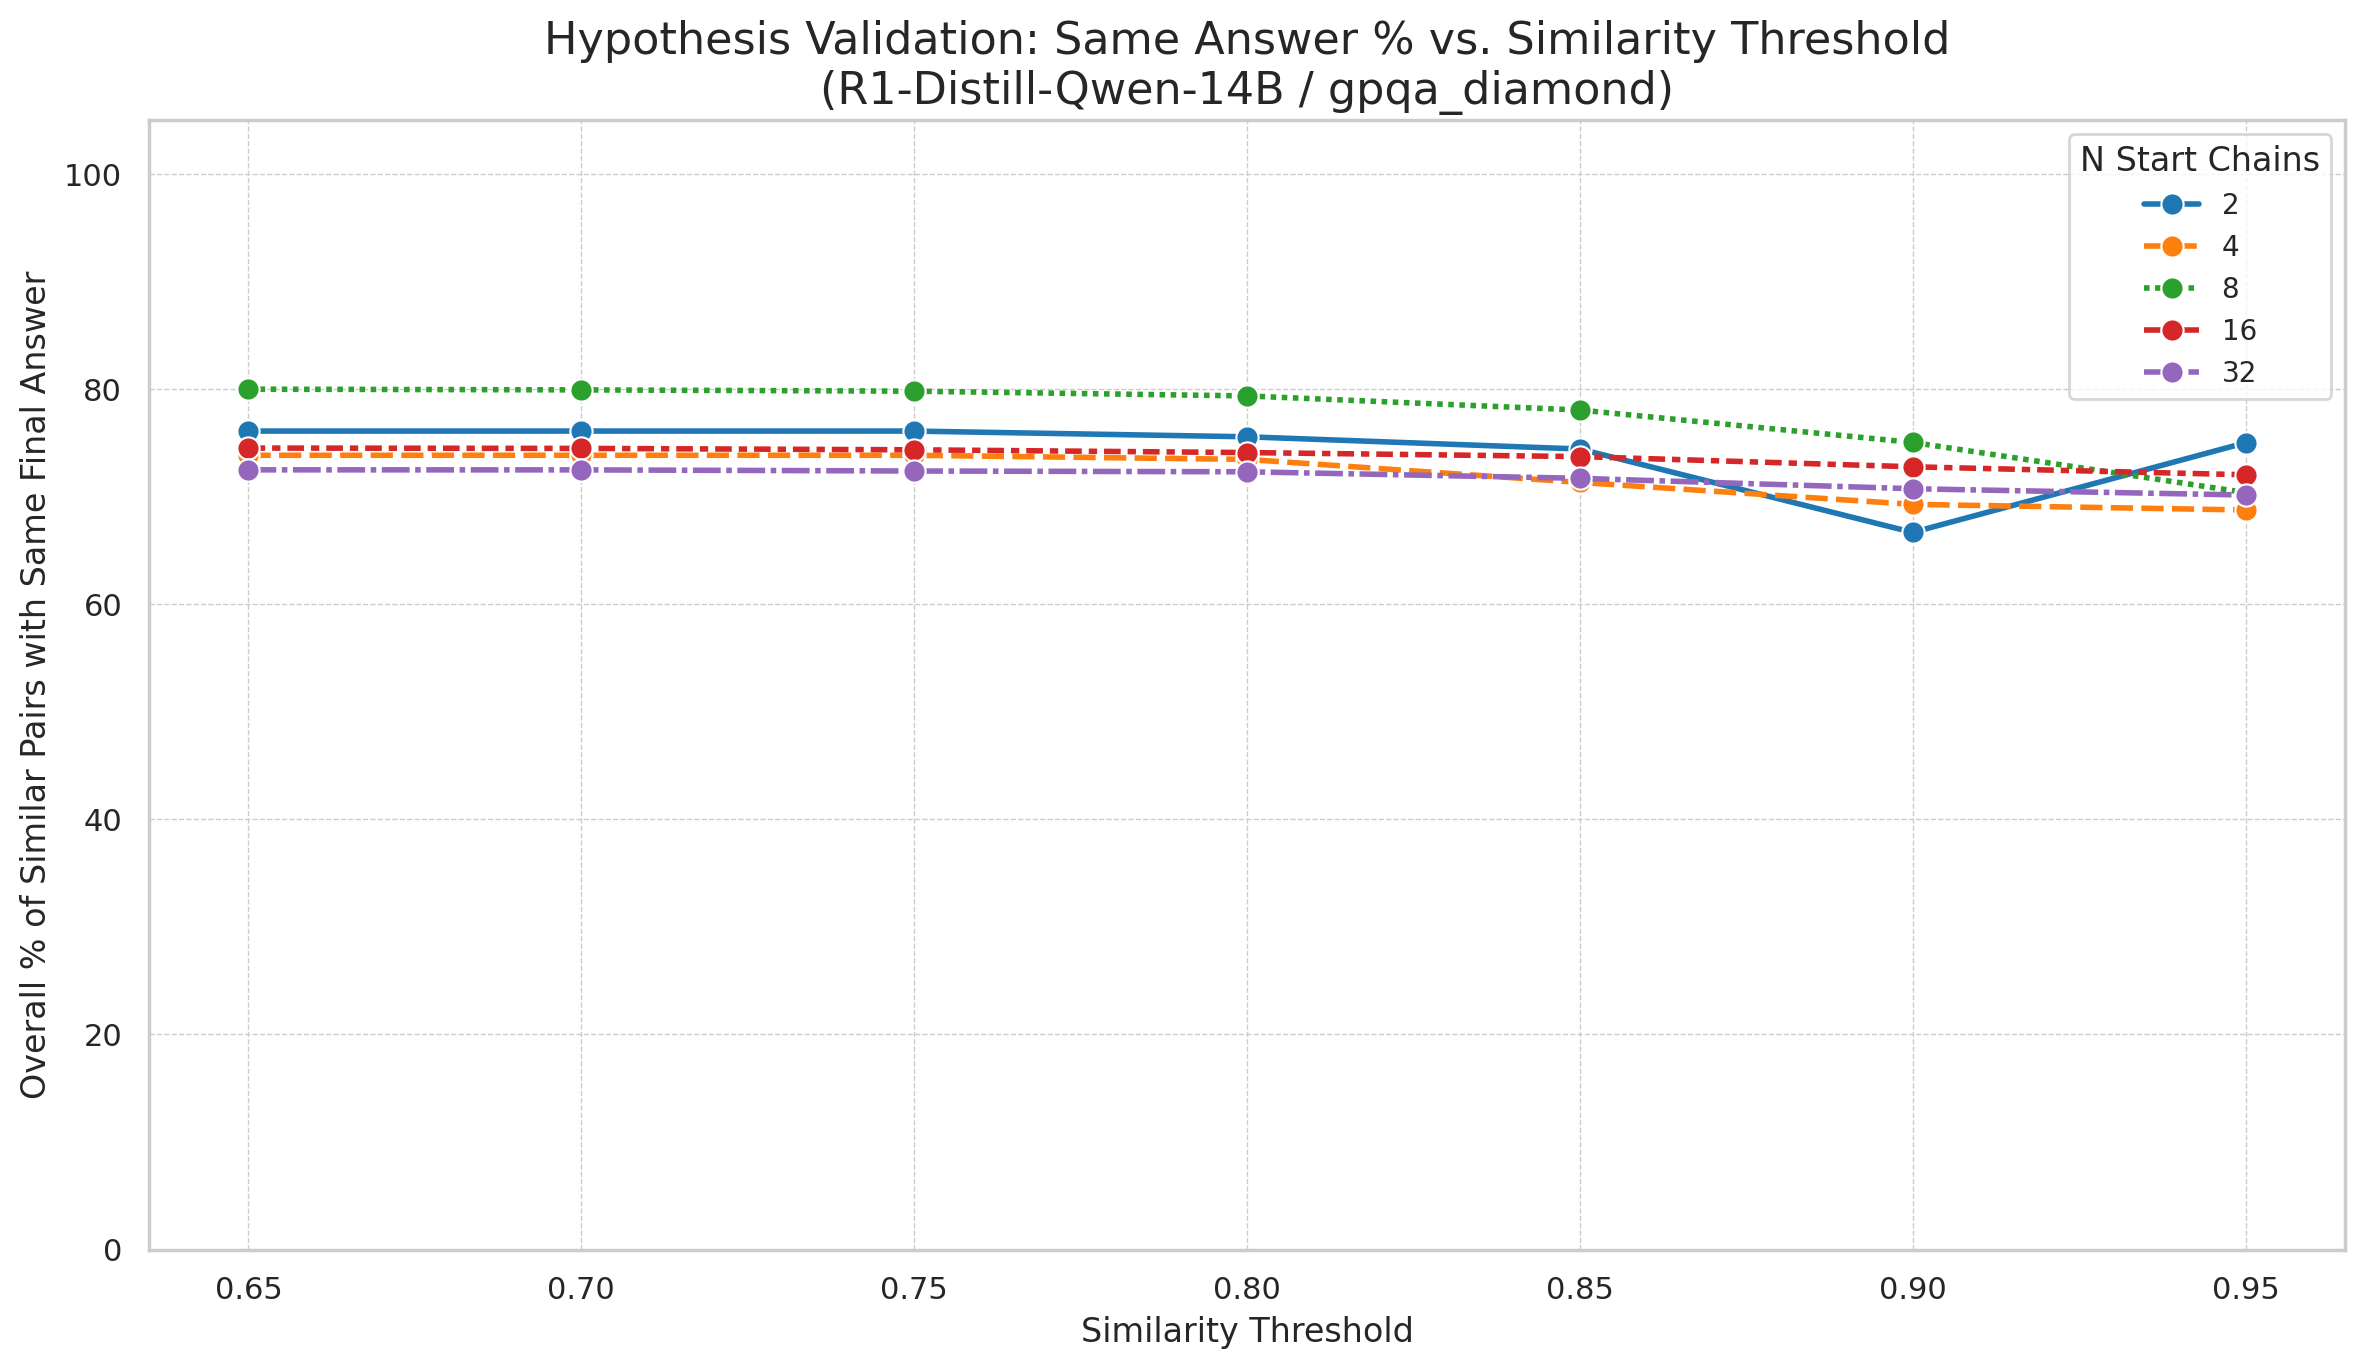


    **Interpretation:**
    This plot shows the core result. Each line represents a different initial number of chains (N).
    The Y-axis shows the percentage of detected similar thought pairs (above the threshold on the X-axis)
    that came from chains which ultimately produced the same final answer.
    - The percentages consistently high, supporting the hypothesis.
    - Percentage generally decreases with the threshold
    - As the similarity threshold increases (moving right on the x-axis), significantly fewer pairs of thoughts will actually meet the threshold (next diagram).
    - The percentage on the y-axis is calculated as (Pairs with Same Answer) / (Total Detected Pairs). When the denominator becomes small (at high thresh.), the percentage becomes highly sensitive to just a few instances.
    - This small sample might include a few "misleadingly similar" pairs (similar thought, different final answer due to later reasoning) or just be subject to random noise, potentially p

In [43]:
if results_df is not None and not results_df.empty:
    plt.figure(figsize=(12, 7))

    # Plot using seaborn's lineplot
    sns.lineplot(
        data=results_df,
        x="threshold",
        y="overall_perc_same",
        hue="n_start",          # Different line color for each n_start
        style="n_start",        # Different marker style for each n_start (optional)
        marker="o",             # Use circles as markers
        markersize=8,
        palette="tab10",      # Choose a color palette
        linewidth=2
    )

    plt.title(f'Hypothesis Validation: Same Answer % vs. Similarity Threshold\n({MODEL_NAME} / {DATASET_NAME})', fontsize=16)
    plt.xlabel("Similarity Threshold", fontsize=12)
    plt.ylabel("Overall % of Similar Pairs with Same Final Answer", fontsize=12)
    plt.ylim(0, 105) # Percentage scale from 0 to 100 (add a little buffer)
    plt.xticks(sorted(results_df['threshold'].unique())) # Ensure all thresholds are marked
    plt.legend(title="N Start Chains", loc='best', fontsize=10) # Adjust legend position
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout() # Adjust layout
    plt.show()

    print("""
    **Interpretation:**
    This plot shows the core result. Each line represents a different initial number of chains (N).
    The Y-axis shows the percentage of detected similar thought pairs (above the threshold on the X-axis)
    that came from chains which ultimately produced the same final answer.
    - The percentages consistently high, supporting the hypothesis.
    - Percentage generally decreases with the threshold
    - As the similarity threshold increases (moving right on the x-axis), significantly fewer pairs of thoughts will actually meet the threshold (next diagram).
    - The percentage on the y-axis is calculated as (Pairs with Same Answer) / (Total Detected Pairs). When the denominator becomes small (at high thresh.), the percentage becomes highly sensitive to just a few instances.
    - This small sample might include a few "misleadingly similar" pairs (similar thought, different final answer due to later reasoning) or just be subject to random noise, potentially pulling the observed average percentage down slightly.
    """)
else:
    print("Skipping Visualization 1 due to missing data.")

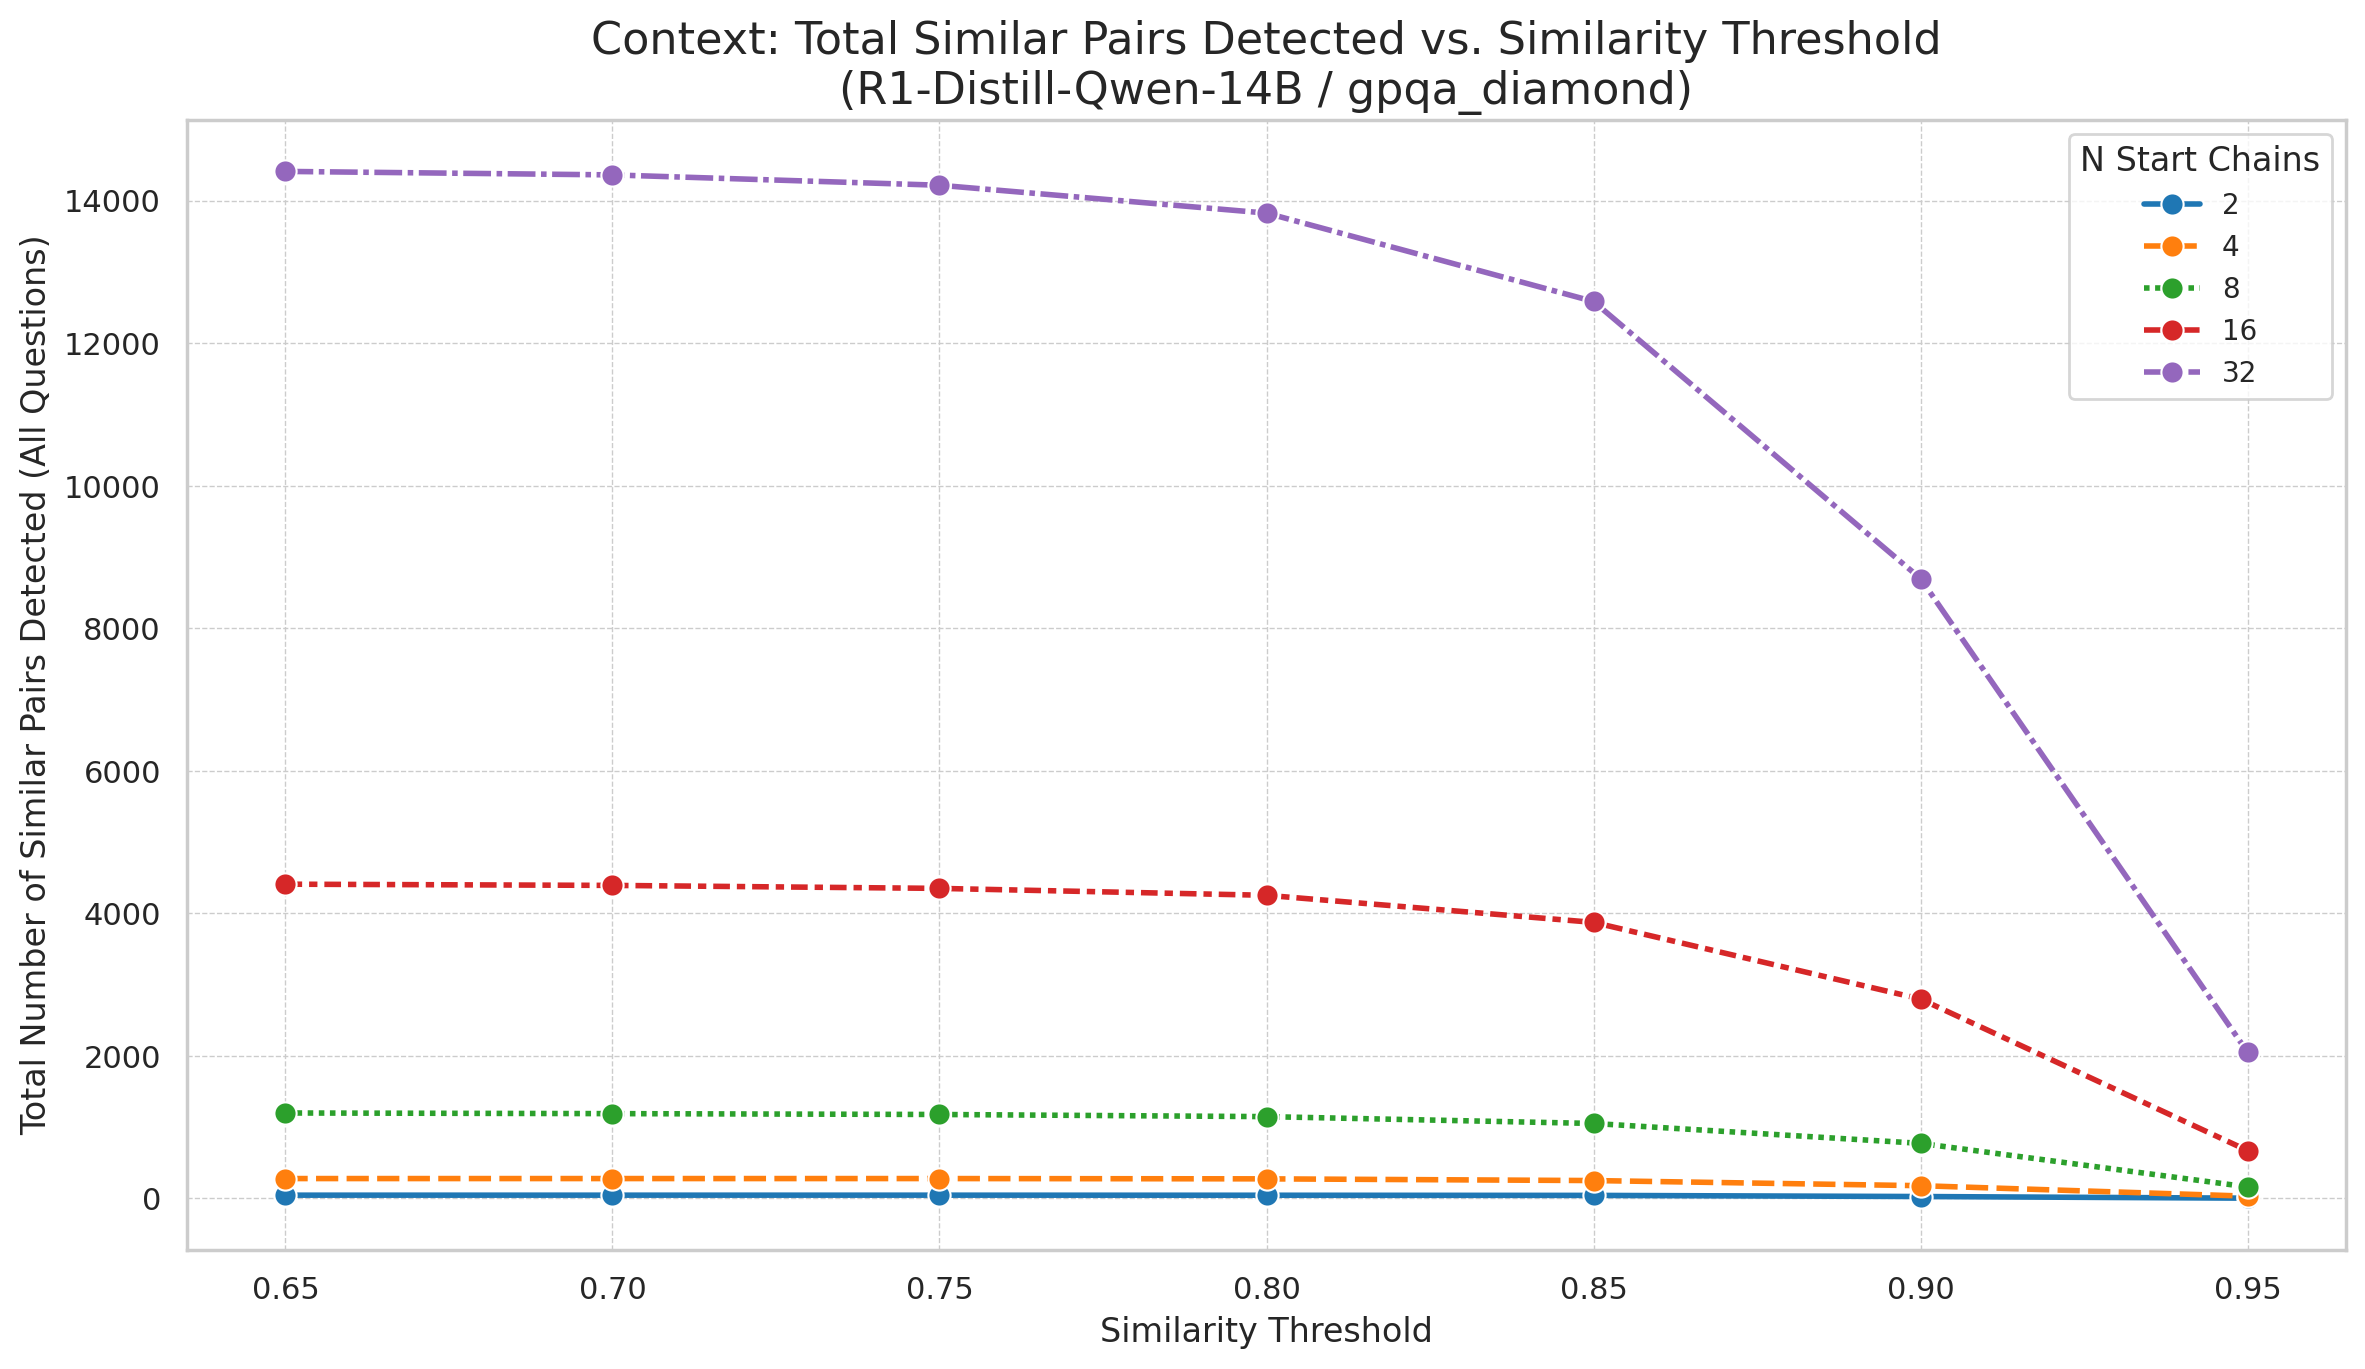


    **Interpretation:**
    This plot shows the number of similar thought pairs detected across all analyzed questions
    for each threshold (X-axis) and initial chain count (N, line color).
    - As the threshold increases, the number of detected pairs should decrease (stricter condition).
    - A higher N generally leads to more detected pairs.
    - Use this to gauge the reliability of the percentages in the previous plot. Low counts might make percentages noisy.
    


In [44]:
if results_df is not None and not results_df.empty:
    plt.figure(figsize=(12, 7))

    sns.lineplot(
        data=results_df,
        x="threshold",
        y="total_detected",
        hue="n_start",
        style="n_start",
        marker="o",
        markersize=8,
        palette="tab10",
        linewidth=2
    )

    plt.title(f'Context: Total Similar Pairs Detected vs. Similarity Threshold\n({MODEL_NAME} / {DATASET_NAME})', fontsize=16)
    plt.xlabel("Similarity Threshold", fontsize=12)
    plt.ylabel("Total Number of Similar Pairs Detected (All Questions)", fontsize=12)
    # Consider log scale if numbers vary widely: plt.yscale('log')
    plt.xticks(sorted(results_df['threshold'].unique()))
    plt.legend(title="N Start Chains", loc='best', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print("""
    **Interpretation:**
    This plot shows the number of similar thought pairs detected across all analyzed questions
    for each threshold (X-axis) and initial chain count (N, line color).
    - As the threshold increases, the number of detected pairs should decrease (stricter condition).
    - A higher N generally leads to more detected pairs.
    - Use this to gauge the reliability of the percentages in the previous plot. Low counts might make percentages noisy.
    """)
else:
    print("Skipping Visualization 2 due to missing data.")

/tmp/ipykernel_1282261/1533314642.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


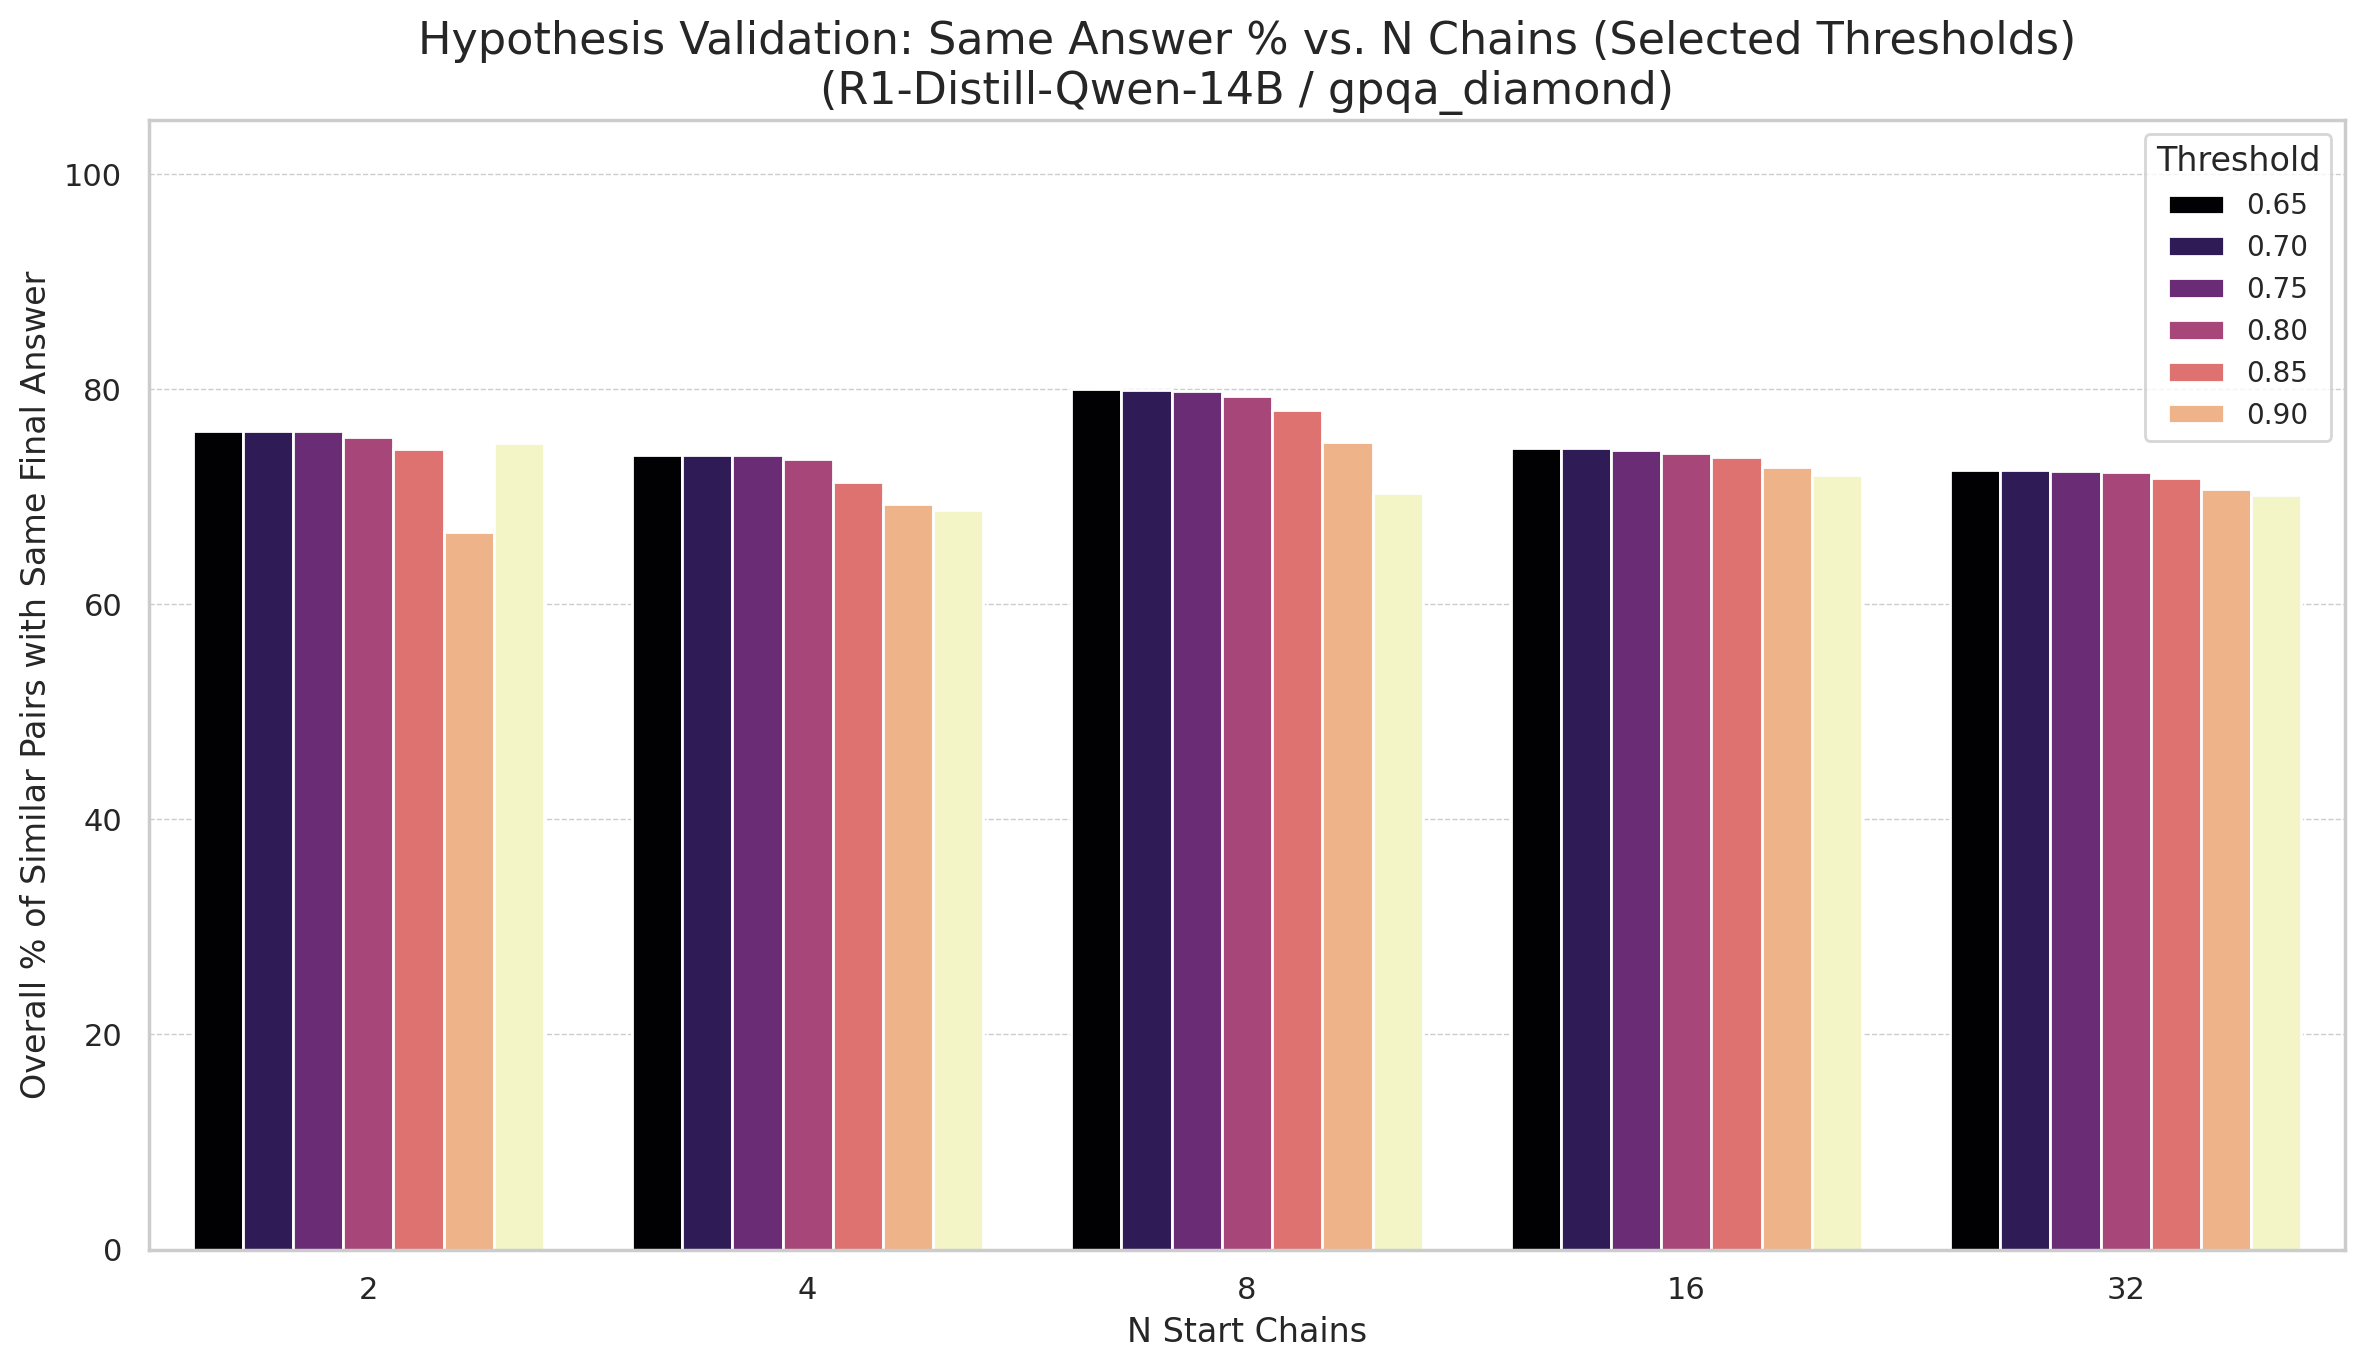

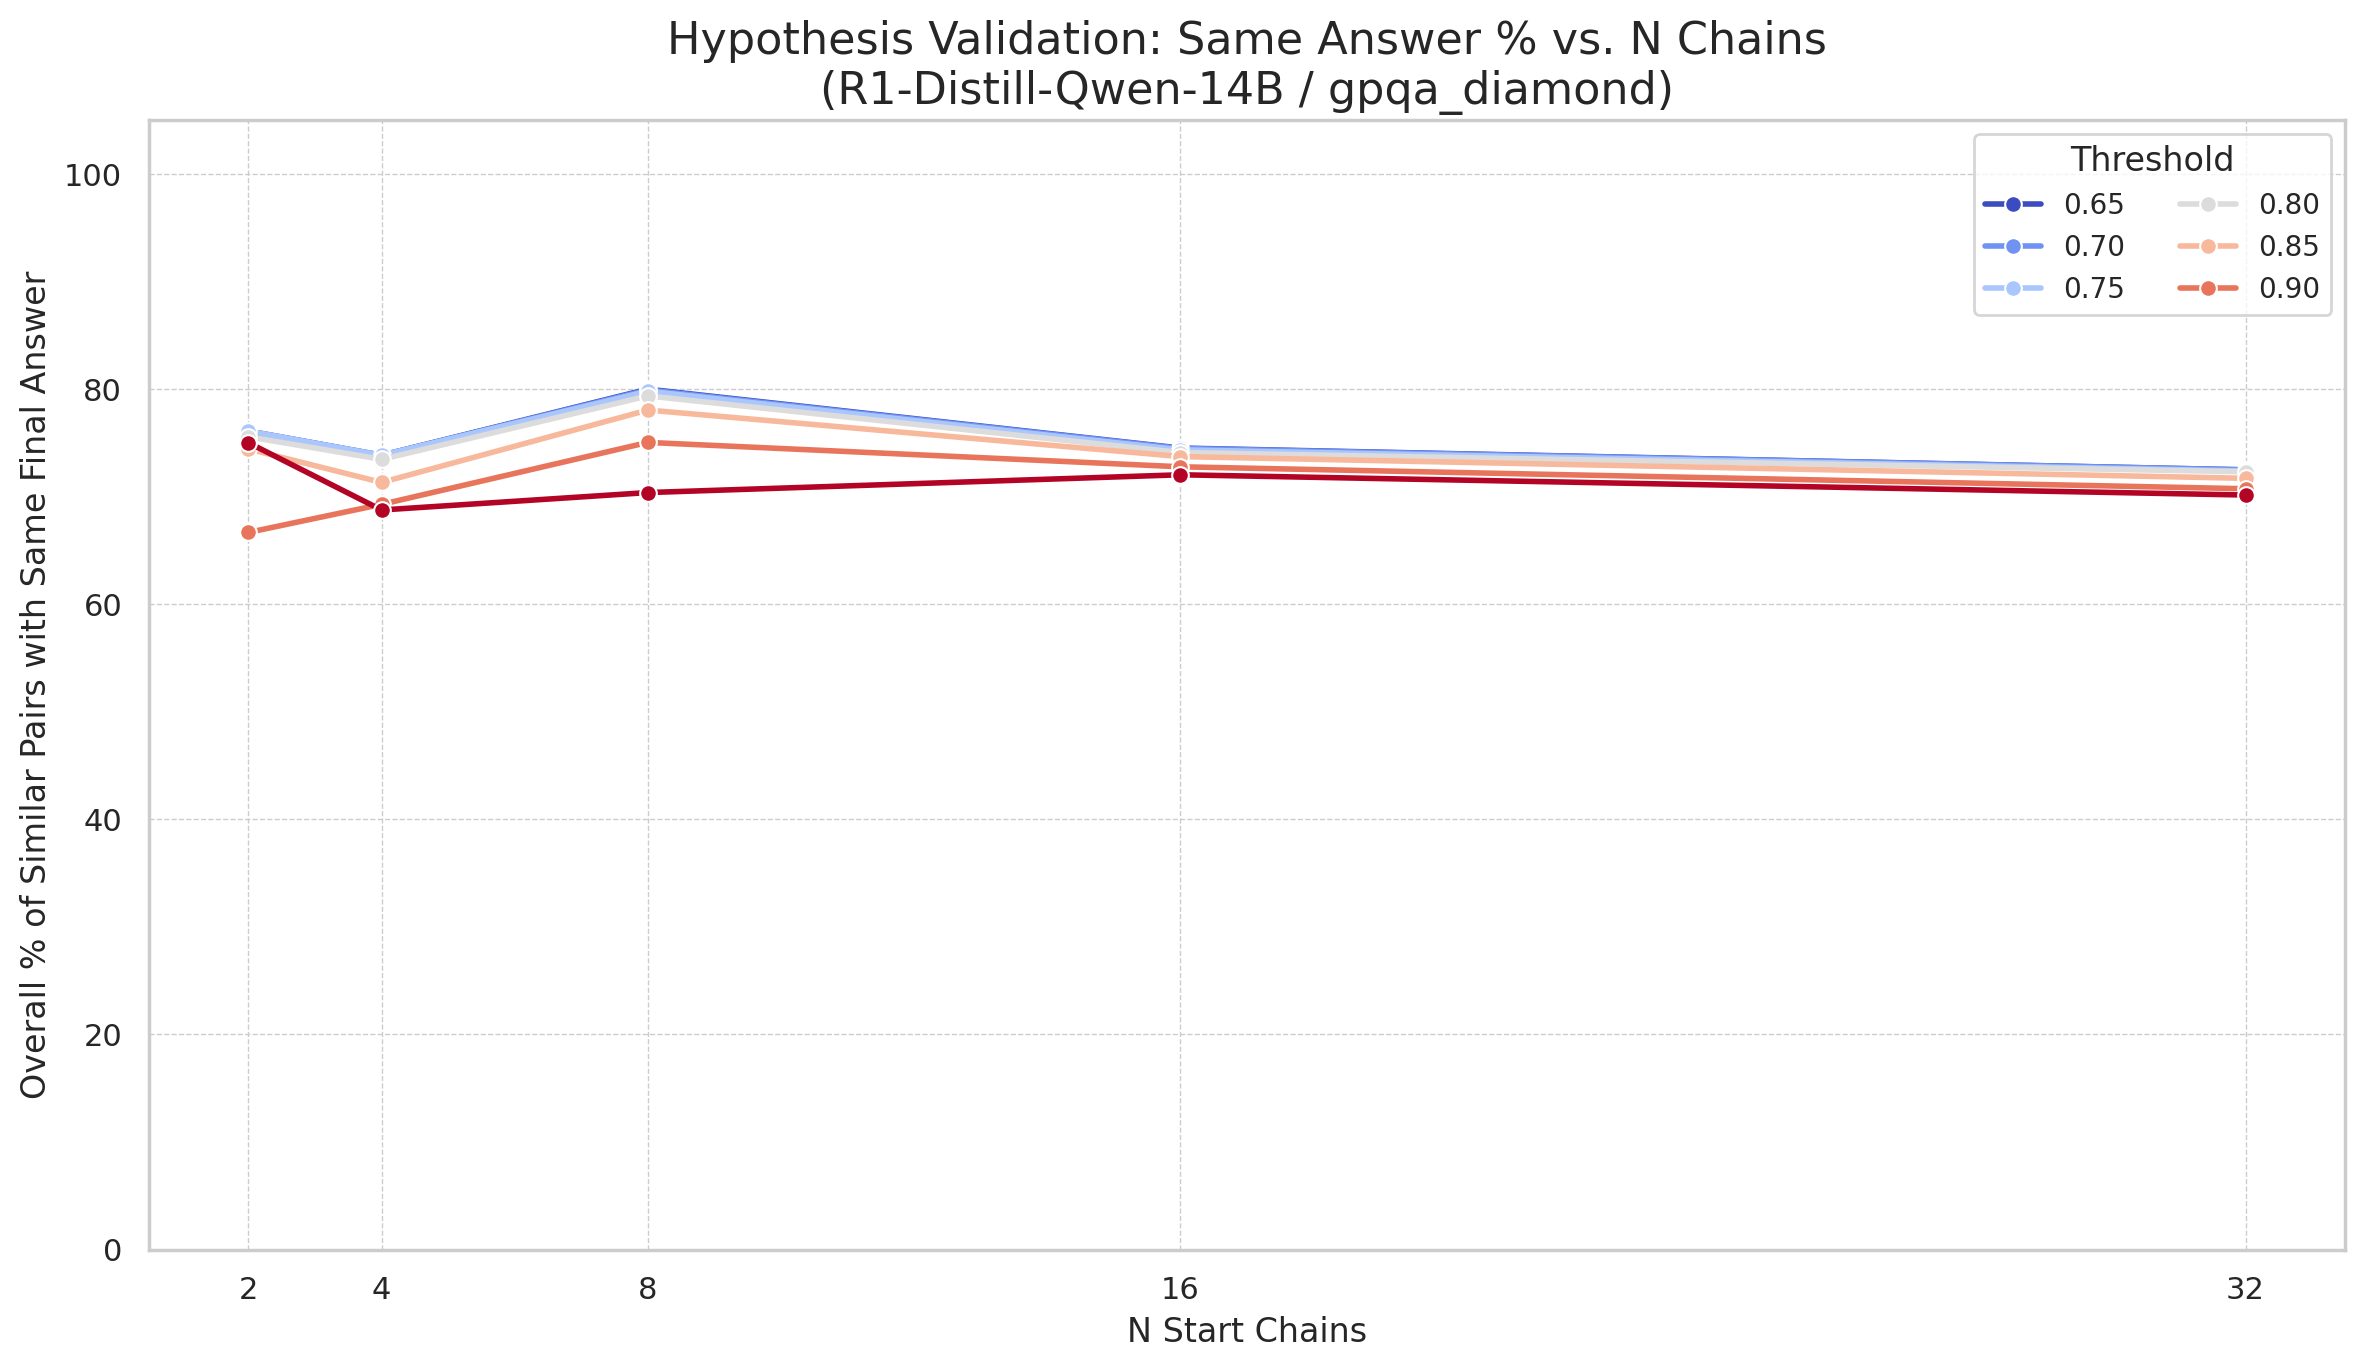


    **Interpretation:**
    These plots show how the percentage of similar pairs leading to the same answer changes as the
    initial number of chains (N) increases.
    - Bar chart: Compares N values side-by-side at specific thresholds.
    - Line plot: Shows the trend across N for all thresholds simultaneously.
    - Seems to have an optimal N=8.
    - Lower thresholds tend to give the same final answer.
    


In [46]:
if results_df is not None and not results_df.empty:
    # Option 1: Grouped Bar Chart (Good for comparing N at specific thresholds)
    # Select a few representative thresholds
    selected_thresholds = [t for t in [0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] if t in results_df['threshold'].unique()]

    if selected_thresholds:
        plt.figure(figsize=(12, 7))
        df_subset = results_df[results_df['threshold'].isin(selected_thresholds)]

        sns.barplot(
            data=df_subset,
            x="n_start",
            y="overall_perc_same",
            hue="threshold",
            palette="magma", # Different palette
            ci=None # No error bars needed for aggregated data
        )

        plt.title(f'Hypothesis Validation: Same Answer % vs. N Chains (Selected Thresholds)\n({MODEL_NAME} / {DATASET_NAME})', fontsize=16)
        plt.xlabel("N Start Chains", fontsize=12)
        plt.ylabel("Overall % of Similar Pairs with Same Final Answer", fontsize=12)
        plt.ylim(0, 105)
        plt.legend(title="Threshold", loc='best', fontsize=10)
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5) # Grid lines on y-axis only
        plt.tight_layout()
        plt.show()

    # Option 2: Line Plot (Good for seeing trend across N for all thresholds)
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=results_df,
        x="n_start",
        y="overall_perc_same",
        hue="threshold", # Color by threshold
        marker="o",
        palette="coolwarm", # Different palette
        linewidth=2
    )
    plt.title(f'Hypothesis Validation: Same Answer % vs. N Chains\n({MODEL_NAME} / {DATASET_NAME})', fontsize=16)
    plt.xlabel("N Start Chains", fontsize=12)
    plt.ylabel("Overall % of Similar Pairs with Same Final Answer", fontsize=12)
    plt.ylim(0, 105)
    plt.xticks(sorted(results_df['n_start'].unique())) # Ensure all N values are marked
    plt.legend(title="Threshold", loc='best', fontsize=10, ncol=2) # Adjust legend columns if many thresholds
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print("""
    **Interpretation:**
    These plots show how the percentage of similar pairs leading to the same answer changes as the
    initial number of chains (N) increases.
    - Bar chart: Compares N values side-by-side at specific thresholds.
    - Line plot: Shows the trend across N for all thresholds simultaneously.
    - Seems to have an optimal N=8.
    - Lower thresholds tend to give the same final answer.
    """)
else:
    print("Skipping Visualization 3 due to missing data.")

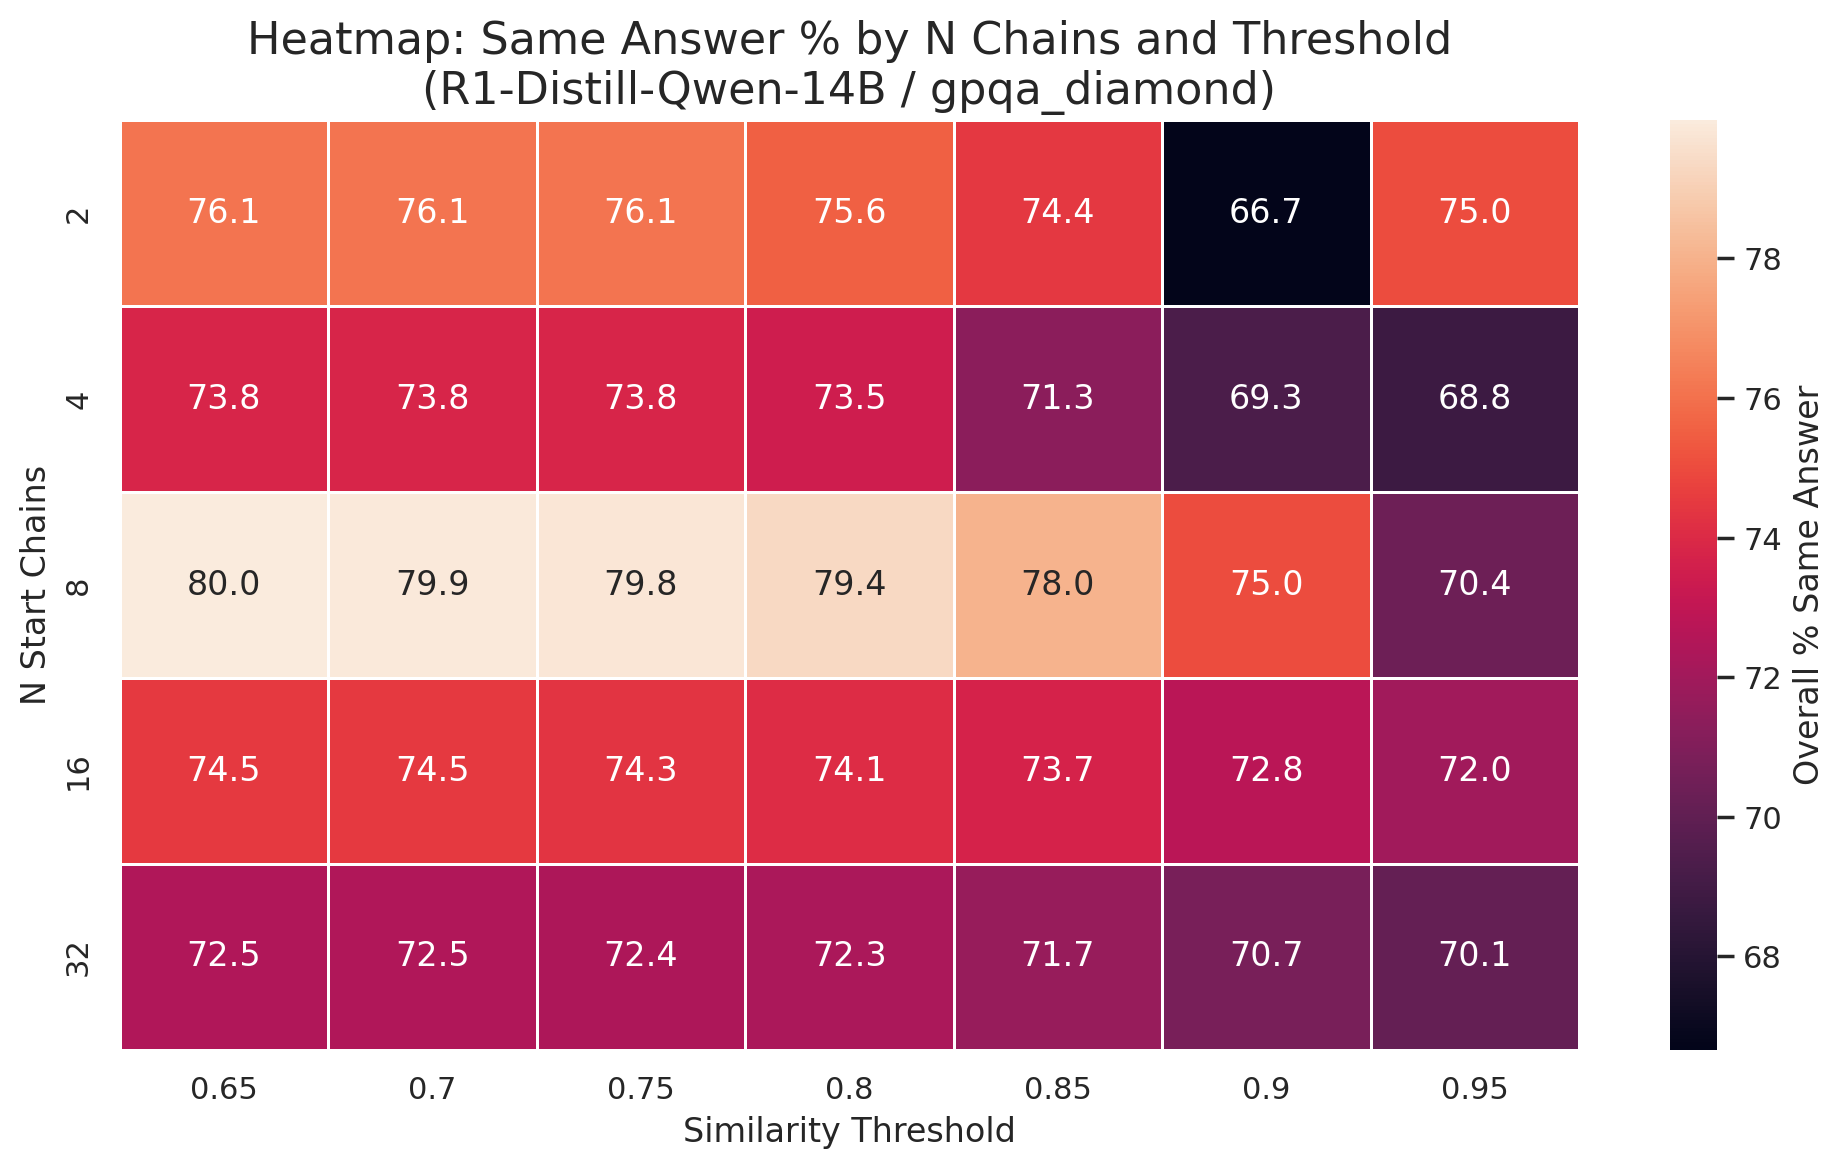


        **Interpretation:**
        This heatmap provides a 2D overview. Each cell shows the overall percentage of similar pairs
        leading to the same final answer for a specific combination of N Chains (Y-axis) and
        Similarity Threshold (X-axis). Darker/Lighter colors (depending on cmap) indicate higher percentages.
        - N=8 between 0.65 and 0.85 depict where the hypothesis holds strongly.
        - Smaller thresholds tend to support the hypothesis more strongly possibly because of more similar thought pairs.
        


In [48]:
if results_df is not None and not results_df.empty:
    try:
        # Pivot the data for the heatmap
        heatmap_data = results_df.pivot(index="n_start", columns="threshold", values="overall_perc_same")

        plt.figure(figsize=(10, 6)) # Adjust size for heatmap aspect ratio
        sns.heatmap(
            heatmap_data,
            annot=True,          # Show the percentage values in the cells
            fmt=".1f",           # Format values to one decimal place
            linewidths=.5,       # Add lines between cells
            cmap="rocket",     # Colormap (can change to 'coolwarm', 'YlGnBu', etc.)
            cbar_kws={'label': 'Overall % Same Answer'} # Label for the color bar
        )
        plt.title(f'Heatmap: Same Answer % by N Chains and Threshold\n({MODEL_NAME} / {DATASET_NAME})', fontsize=16)
        plt.xlabel("Similarity Threshold", fontsize=12)
        plt.ylabel("N Start Chains", fontsize=12)
        plt.tight_layout()
        plt.show()

        print("""
        **Interpretation:**
        This heatmap provides a 2D overview. Each cell shows the overall percentage of similar pairs
        leading to the same final answer for a specific combination of N Chains (Y-axis) and
        Similarity Threshold (X-axis). Darker/Lighter colors (depending on cmap) indicate higher percentages.
        - N=8 between 0.65 and 0.85 depict where the hypothesis holds strongly.
        - Smaller thresholds tend to support the hypothesis more strongly possibly because of more similar thought pairs.
        """)
    except Exception as e:
        print(f"Could not generate heatmap, possibly due to data shape issues: {e}")
        print("Heatmaps require data for all combinations of index and columns after pivoting.")

else:
    print("Skipping Visualization 4 due to missing data.")